# Ensemble Analysis

This notebook reads in and formats outputs from ensemble simulations so that you can evaluate and plot

### Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os


#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

# Setup static variables

In [2]:
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers
dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ensembles = [[1,1,1,1,3,3,1],
[1,2,2,1,1,2,2], 
[2,1,3,3,2,1,3],
[2,2,2,2,3,3,3],
[2,1,3,3,1,2,2],
[2,2,3,3,1,1,2],
[2,1,1,2,2,2,3],
[2,2,3,3,2,1,1],
[2,1,2,3,2,2,1],
[3,3,3,3,3,3,3]]

n_ens = len(ensembles)
print(n_ens, 'Ensembles to evaluate')


10 Ensembles to evaluate


## Read in the heads and create timeseries at points

In [3]:
#setup well locations and observation points
well_loc = (2,21, 38) #town well 
welli_loc = (2,12, 14) #ag irrigation well 
#observation well
#wello_loc = (2, 15, 15)  # ag observation well we want this in top layer to observe the water table depth

#setup timeseries
head_ts = []  # timeseries of head at town well
ag_head_ts = []  # timeseries of head at agg well
#mw1_head_ts = []  # timeseries of head at observation well

# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
   

   ## CHANGED THESE TO NP.MEAN()
    #Extract out time series of heads at points of interest
    #head_ts.append(np.mean(headobj.get_ts(well_loc)))        #town well
    #ag_head_ts.append(np.mean(headobj.get_ts(welli_loc)))    #ag well
    head_ts.append(headobj.get_ts(well_loc))        #town well
    ag_head_ts.append(headobj.get_ts(welli_loc))    #ag well

    times = headobj.get_times()
    #print(budgobj.get_unique_record_names())

## Store complete gridded outputs as arrays

In [4]:
#setup arrays to store the values
head_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))  #4D array with shape time, layer, col, row for each ensemble
frf_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
fff_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
recharge_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))
et_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))
stor_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))

# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')   

    rowcounter = -1
    for t in times:
        rowcounter += 1
        head_array[i, rowcounter,:, :, :] = headobj.get_data(totim=t)
        
        tempfrf = np.squeeze(budgobj.get_data(text='flow right face', totim=t))
        frf_array[i, rowcounter,:, :, :] = tempfrf
        
        tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE', totim=t))
        fff_array[i, rowcounter,:, :, :] = tempfff

        temprch = np.squeeze(budgobj.get_data(text='RECHARGE', totim=t))
        recharge_array[i, rowcounter, :, :, :] = temprch[1]

        tempet = np.squeeze(budgobj.get_data(text='ET', totim=t))
        et_array[i, rowcounter, :, :, :] = tempet[1]


## Read in the river leakage

In [5]:
#setup arrays to store the values
leakage_array = np.zeros((len(ensembles), len(times), 49))

# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #water budget files
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')   

    rowcounter = -1
    for t in times:
        rowcounter += 1

        templeak = budgobj.get_data(text='RIVER LEAKAGE', totim=t)
        leakage_array[i, rowcounter,:] = templeak[0].q

## Sum the leakage along entire river length for each model in the ensemble individually

In [59]:
#print(np.shape(leakage_array))
first = np.sum(leakage_array[0][0][:]) #leakage for first model in the ensemble
second =np.sum(leakage_array[1][0][:])
third =  np.sum(leakage_array[2][0][:])
fourth= np.sum(leakage_array[3][0][:])
fifth= np.sum(leakage_array[4][0][:])
sixth= np.sum(leakage_array[5][0][:])
seventh= np.sum(leakage_array[6][0][:])
eighth= np.sum(leakage_array[7][0][:])
ninth= np.sum(leakage_array[8][0][:])
tenth= np.sum(leakage_array[9][0][:])
print(first, second,third, fourth, fifth, sixth, seventh, eighth, ninth, tenth)
leakage_list = [first, second,third, fourth, fifth, sixth, seventh, eighth, ninth, tenth]

6000.0 10404.514508247375 30083.16498851776 141517.88342285156 24130.394740104675 31302.573694229126 44279.91935348511 14405.86172914505 14888.934244632721 334712.64052963257


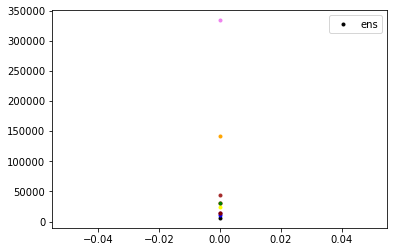

In [101]:
leakage_list = [first, second,third, fourth, fifth, sixth, seventh, eighth, ninth, tenth]
plt.plot(leakage_list[0],'.', color = 'black', label = 'ens')
plt.plot(leakage_list[1],'.', color = 'blue')
plt.plot(third,'.', color = 'red')
plt.plot(fourth,'.', color = 'orange')
plt.plot(fifth,'.', color = 'yellow')
plt.plot(sixth,'.', color = 'green')
plt.plot(seventh,'.', color = 'brown')
plt.plot(eighth,'.', color = 'purple')
plt.plot(ninth,'.', color = 'maroon')
plt.plot(tenth,'.', color = 'violet')
plt.legend()
plt.show()

### Head value for each model at the town well

In [81]:
print(np.shape(head_ts))
#np.shape(head_ts[0][0][0])
print('first model',head_ts[0][0][1])
print('second model',head_ts[1][0][1])
print('third model',head_ts[2][0][1])
#head1 = head_ts[0][0][1]
#head2= head_ts[1][0][1]
#head3= head_ts[2][0][1]
#head4= head_ts[3][0][1]
#head5= head_ts[4][0][1]
#head6= head_ts[5][0][1]
#head7= head_ts[6][0][1]
#head8= head_ts[7][0][1]
#head9= head_ts[8][0][1]
#head10= head_ts[9][0][1]
#print(head1, head2, head3, head4, head5, head6, head7, head8, head9, head10)
town_list = [[head1, head2, head3, head4, head5, head6, head7, head8, head9, head10]]


(10, 36, 2)
first model 65.47427
second model 73.106834
third model 74.24825
65.47427 73.106834 74.24825 74.47826 74.2824 75.21399 74.069305 74.19402 73.34648 75.39993


### Head for each model at the Ag well

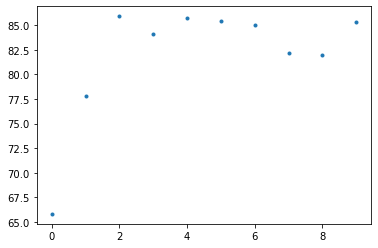

In [89]:
#ag_head1 = ag_head_ts[0][0][1]
#ag_head2= ag_head_ts[1][0][1]
#ag_head3= ag_head_ts[2][0][1]
#ag_head4= ag_head_ts[3][0][1]
#ag_head5= ag_head_ts[4][0][1]
#ag_head6= ag_head_ts[5][0][1]
#ag_head7= ag_head_ts[6][0][1]
#ag_head8= ag_head_ts[7][0][1]
#ag_head9= ag_head_ts[8][0][1]
#ag_head10= ag_head_ts[9][0][1]
#print(ag_head1, ag_head2, ag_head3, ag_head4, ag_head5, ag_head6, ag_head7, ag_head8, ag_head9,ag_head10)
ag_list = [ag_head1, ag_head2, ag_head3, ag_head4, ag_head5, ag_head6, ag_head7, ag_head8, ag_head9,ag_head10]
plt.plot(ag_list,'.')

# Plot all ensembles together

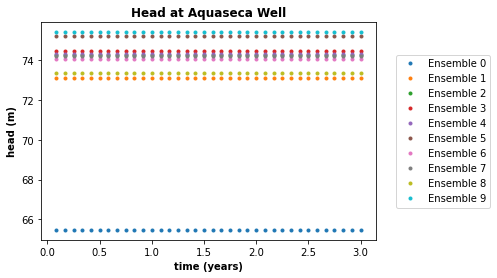

In [43]:
#Head at Aquaseca well 
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
# plt.ylim(75.2,75.8)
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(head_ts[j][:, 0]/360, head_ts[j][:, 1],'.', label=label) #plot the time series with points at each record
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
plt.savefig("Head_Aqua_ensem.png",dpi=600)
plt.show()


### Same as the plot above but trying to have only one datapoint per model

ValueError: x and y must have same first dimension, but have shapes (2,) and (36,)

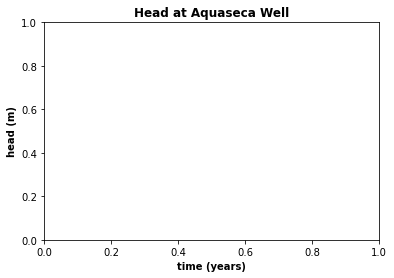

In [26]:
#Try to plot a single timestep
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
# plt.ylim(75.2,75.8)
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(head_ts[j][:, 0]/360, head_ts[j][:, 1], label=label) #plot the time series with points at each record
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
plt.savefig("Head_Aqua_ensem.png",dpi=600)
plt.show()

### Head at observation well
plt.subplot(1, 1, 1)
plt.title("Head at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(mw1_head_ts[j][:, 0]/360, mw1_head_ts[j][:, 1], label=label) #plot the time series with points at each record
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
plt.savefig("Head_M1_ensem.png",dpi=600)
plt.show()

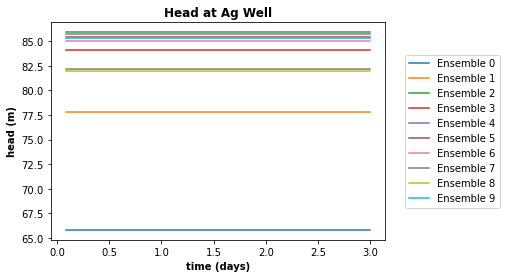

In [8]:
#Ag Well Plot
plt.subplot(1, 1, 1)
plt.title("Head at Ag Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(ag_head_ts[j][:, 0]/360, ag_head_ts[j][:, 1], label=label) #plot the time series with points at each record

plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
plt.savefig("Head_irri_ensem.png",dpi=600)
plt.show()

## Get one value for each model at ag well

## Alternate approach: Read in variables and store as dictionaries

In [9]:
#setup some structures to store data in 
head = np.tile({}, n_ens)
leakage = np.tile({}, n_ens)
fff = np.tile({}, n_ens)
stor = np.tile({}, n_ens)
recharge = np.tile({}, n_ens)
et = np.tile({}, n_ens)
frf = np.tile({}, n_ens)


# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   
                   
    head[i] = {}
    leakage[i] = {}
    fff[i] = {}
    stor[i] = {}
    recharge[i] = {}
    et[i] = {}
    frf[i] = {}

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')
   
    #store the complete arrays in dictionaries
    for stress_per, time in enumerate(times): #iterate through times at end of each stress period
        head[i]['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
        leakage[i]['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) #append right face flow to frf list for ea stress per
        fff[i]['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
        frf[i]['sp%s'%(stress_per)] = budgobj.get_data(text='flow right face', totim=time)
        stor[i]['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
        recharge[i]['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE', totim=time) 
        et[i]['sp%s'%(stress_per)] = budgobj.get_data(text='ET', totim=time) 

In [10]:
#to specify the head at a point, indicate the row and column
print('# ensembles, # timesteps, # layers, # nrow, # ncol') 
print(np.shape(head_array))


# ensembles, # timesteps, # layers, # nrow, # ncol
(10, 36, 3, 50, 50)


In [11]:
#single head value at town well location
print(head_array[0,0,2,21,38])  #1st model, 1st timestep, bottom layer, 21, 38 (town well row and column)
#town loc, top layer
print('town top layer')
print(head_array[0,0,0,21,38])

65.47427368164062
town top layer
68.09163665771484


#### Plot head contours

In [12]:
#####################################################################
# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model

contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)

NameError: name 'm' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model